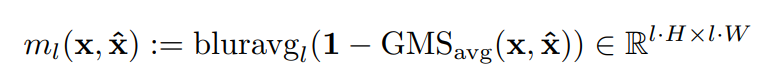

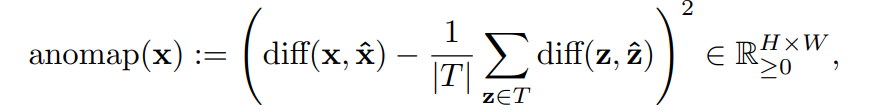

In [1]:
import torch
import torch.nn.functional as F
import math
from msgms import MSGMSLoss
from PIL import Image
import torch
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import os
from dataset import MVTecAD_loader
from model import InTra
from PIL import Image
import torch
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import numpy as np

from ipywidgets import interact
import ipywidgets as widgets



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def create_gaussian_kernel(kernel_size, sigma):
    """Create a Gaussian kernel."""
    gauss = torch.tensor([math.exp(-x**2 / (2 * sigma**2)) for x in range(-kernel_size//2 + 1, kernel_size//2 + 1)])
    gauss = gauss / gauss.sum()
    gauss = gauss.view(1, -1) * gauss.view(-1, 1)
    return gauss.view(1, 1, kernel_size, kernel_size)

def apply_averaging_and_gaussian_filter(input_tensor, scale_factor, gauss_kernel_size=7, gauss_sigma=2):
    # Original spatial dimensions
    original_size = input_tensor.shape[-2:]

    # Create a uniform averaging kernel, adjusting for channel dimension
    channels = input_tensor.size(1)
    avg_kernel = torch.ones(channels, 1, scale_factor, scale_factor) / (scale_factor**2)
    avg_kernel = avg_kernel.to(input_tensor.device)

    # Apply convolution with stride equal to scale factor (for downsampling)
    downsampled_tensor = F.conv2d(input_tensor, avg_kernel, stride=scale_factor, padding=0, groups=channels)

    # Create Gaussian kernel
    gauss_kernel = create_gaussian_kernel(gauss_kernel_size, gauss_sigma).to(input_tensor.device)
    gauss_kernel = gauss_kernel.repeat(channels, 1, 1, 1)

    # Apply Gaussian blur
    smoothed_tensor = F.conv2d(downsampled_tensor, gauss_kernel, padding=gauss_kernel_size // 2, groups=channels)

    # Resize to original dimensions using bilinear interpolation
    resized_tensor = F.interpolate(smoothed_tensor, size=original_size, mode='bilinear', align_corners=False)

    return resized_tensor

def avg_multiscale(input_tensor, scale_factors=[1/2,1/4], gauss_kernel_size=7, gauss_sigma=2):
    smoothed_tensors = []
    for scale_factor in scale_factors:
        smoothed_tensors.append(apply_averaging_and_gaussian_filter(input_tensor, scale_factor, gauss_kernel_size, gauss_sigma))
    stacked_tensor = torch.stack(smoothed_tensors, dim=0)
    diff = torch.mean(stacked_tensor, dim=0)   
    return diff

# get some metrics of a tensor
def met(tensor):
    return (f"{{'Max': {tensor.max().item():.2f},'Min': {tensor.min().item():.2f},'Mean': {tensor.mean().item():.2f},"f"'Sd': {tensor.std().item():.2f},"f"'Median': {tensor.median().item():.2f},"f"'Sum': {tensor.sum().item():.2f},"f"'Product': {tensor.prod().item():.2f}}}")

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])



def process_and_plot_tensors(image_tensor1, image_tensor1_pred,type="Normal" ,mean_z_diff=None):
    msgms = MSGMSLoss()

    # Process the first pair of tensors
    loss1, map1 = msgms(image_tensor1.unsqueeze(0), image_tensor1_pred.unsqueeze(0))
    if mean_z_diff is not  None:

        diff1 = avg_multiscale(map1, scale_factors=[2, 4], gauss_kernel_size=21, gauss_sigma=2)-mean_z_diff
    else:
        diff1 = avg_multiscale(map1, scale_factors=[2, 4], gauss_kernel_size=21, gauss_sigma=2)
        
    diff_squared1 = diff1**2

    # Plotting
    fig, axs = plt.subplots(1, 4, figsize=(10, 10))
    axs[0].imshow(image_tensor1.permute(1, 2, 0))
    axs[0].set_title(f'Original image: {type}')
    axs[0].axis('off')

    axs[1].imshow(image_tensor1_pred.permute(1, 2, 0))
    axs[1].set_title(f'(Reconstructed (theirs))  \n Fully inpainted image: {type} ')
    axs[1].axis('off')

    axs[2].imshow(map1.squeeze(0).permute(1, 2, 0))
    axs[2].set_title('msgms map (theirs)')
    axs[2].axis('off')

    axs[3].imshow(diff_squared1.squeeze(0).permute(1, 2, 0))
    axs[3].set_title('Anomap(x) (own)')
    axs[3].axis('off')
    
    plt.title(f'{type}')
    plt.tight_layout()
    plt.show()
    
def get_mean_Z(RES_PATH,IMG_PATH,ano_class='bottle'):
    if not os.path.exists(f'{ano_class}_mean_Z.pt'):
        model = InTra(grid_size_max=int(256/16)).to(device)
        model_state_dict = torch.load(os.path.join(RES_PATH, 'model_best.nn'), map_location='cuda') # last nn
        model.load_state_dict(model_state_dict)
        model.eval()        
        
        train_loader, _ = MVTecAD_loader(IMG_PATH, (256,256), 1, 1, num_workers=24, is_inference=True,Z_score=True)
        
        # get the mean of the msgms map of the training set
        with torch.no_grad():
            msgms_map_list = []
            for data, label in train_loader:
                data = data.to(device)
                _, _, _, msgms_map =  model._process_one_image(data)
                msgms_map_list.append(msgms_map)
            
            msgms_map_stacked = torch.vstack(msgms_map_list)
            msgms_map_stacked = torch.mean(msgms_map_stacked, dim=0, keepdim=True)

        torch.save(msgms_map_stacked, f'{ano_class}_mean_Z.pt')    
    else:
        print('file already exists')
    
# # Example usage
# input_tensor = torch.randn(5, 1, 20, 20)  # Batch size of 5, 1 channel, 20x20 dimensions
# final = avg_multiscale(input_tensor, scale_factors=[2, 4], gauss_kernel_size=5, gauss_sigma=2)
# print(final.shape)  # Expected shape: (5, 1, 20, 20)

RES_PATH=f'/home/bule/projects/inpainting-transformer/ckpt'
IMG_PATH='/home/bule/projects/MVTec_Visualizer/data/mvtec_anomaly_detection/bottle'
RESULTS_PATH='/home/bule/projects/inpainting-transformer/ckpt/results'


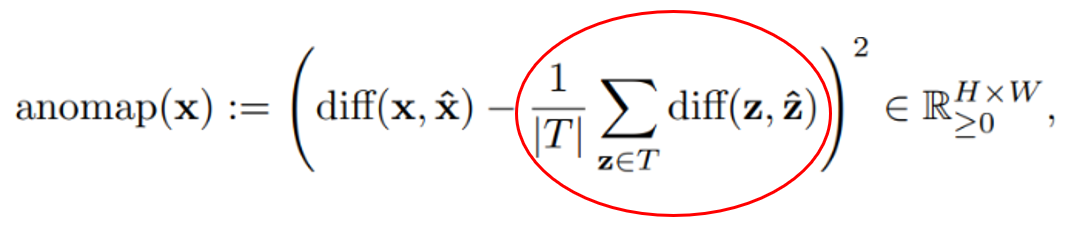

label not exists:  /home/bule/projects/MVTec_Visualizer/data/mvtec_anomaly_detection/bottle/test/good/001.png
label not exists:  /home/bule/projects/MVTec_Visualizer/data/mvtec_anomaly_detection/bottle/test/good/011.png
label not exists:  /home/bule/projects/MVTec_Visualizer/data/mvtec_anomaly_detection/bottle/test/good/012.png
label not exists:  /home/bule/projects/MVTec_Visualizer/data/mvtec_anomaly_detection/bottle/test/good/013.png
label not exists:  /home/bule/projects/MVTec_Visualizer/data/mvtec_anomaly_detection/bottle/test/good/019.png
label not exists:  /home/bule/projects/MVTec_Visualizer/data/mvtec_anomaly_detection/bottle/test/good/009.png
label not exists:  /home/bule/projects/MVTec_Visualizer/data/mvtec_anomaly_detection/bottle/test/good/007.png
label not exists:  /home/bule/projects/MVTec_Visualizer/data/mvtec_anomaly_detection/bottle/test/good/003.png
label not exists:  /home/bule/projects/MVTec_Visualizer/data/mvtec_anomaly_detection/bottle/test/good/016.png
label not 

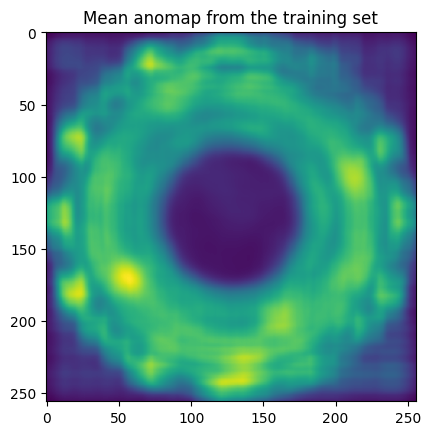

In [3]:
# mean from the training set
get_mean_Z(RES_PATH,IMG_PATH,ano_class='bottle') # calculation and save
mean_z_diff = torch.load('bottle_mean_Z.pt').cpu()
plt.title('Mean anomap from the training set')
plt.imshow(mean_z_diff.squeeze(0).permute(1, 2, 0))

In [ ]:
# TODO HIST:- training loss, validation loss, test good, test anomaly 

# check val loss same scale as 

## Real Predicitons


In [4]:

types=['broken_large','broken_small','contamination','good']
good_real=[(os.path.join(RESULTS_PATH,img),img,img[:-10] ) for img  in os.listdir(RESULTS_PATH) if 'good' in img and 'image'in img]
good_pred=[(os.path.join(RESULTS_PATH,img),img,img[:-10] ) for img  in os.listdir(RESULTS_PATH) if 'good' in img and 'recon'in img]

ano_real=[(os.path.join(RESULTS_PATH,img),img,img[:-10] ) for img  in os.listdir(RESULTS_PATH) if 'good' not in img and 'image'in img]
ano_pred=[(os.path.join(RESULTS_PATH,img),img,img[:-10]) for img  in os.listdir(RESULTS_PATH) if 'good' not in img and 'recon'in img]

# pairs good and recon 
good_real_pred=[(real[0],pred[0]) for real in good_real for pred in good_pred if real[2]==pred[2]]
ano_real_pred=[(real[0],pred[0]) for real in ano_real for pred in ano_pred if real[2]==pred[2]]

len(good_real_pred),len(ano_real_pred)

(20, 63)

### Real vs. Reconstructuted  "Good" "Normal"

In [5]:
nr_slider = widgets.IntSlider(min=0, max=len(good_real_pred)-1, step=1, value=0, description='image')
def load_and_show(nr):
    real,pred =good_real_pred[nr]
    image_tensor1 = transform(Image.open(real))
    image_tensor1_pred = transform(Image.open(pred))
    process_and_plot_tensors(image_tensor1, image_tensor1_pred, type='good',mean_z_diff=mean_z_diff)#mean_z_diff=mean_z_diff)
interact(load_and_show, nr=nr_slider)

interactive(children=(IntSlider(value=0, description='image', max=19), Output()), _dom_classes=('widget-intera…

<function __main__.load_and_show(nr)>

### Real vs. Reconstructed Anomalies

In [6]:
nr_slider = widgets.IntSlider(min=0, max=len(ano_real_pred)-1, step=1, value=0, description='image')
def load_and_show(nr):
    real,pred =ano_real_pred[nr]
    image_tensor1 = transform(Image.open(real))
    image_tensor1_pred = transform(Image.open(pred))
    process_and_plot_tensors(image_tensor1, image_tensor1_pred, type='Anomaly',mean_z_diff=mean_z_diff)#
interact(load_and_show, nr=nr_slider)

interactive(children=(IntSlider(value=0, description='image', max=62), Output()), _dom_classes=('widget-intera…

<function __main__.load_and_show(nr)>

In [7]:
good_max,ano_max,good_mean,ano_mean,loss_good,loss_ano=[],[],[],[],[],[]
msgms=MSGMSLoss()

for paths in good_real_pred:
    image_tensor1 = transform(Image.open(paths[0]))
    image_tensor2 = transform(Image.open(paths[1]))
    
    loss, map =msgms(image_tensor1.unsqueeze(0),image_tensor2.unsqueeze(0))
    diff = avg_multiscale(map, scale_factors=[2, 4], gauss_kernel_size=21, gauss_sigma=2)-mean_z_diff
    diff_squared1 = diff**2
    good_max.append(diff_squared1.max().item())
    good_mean.append(diff_squared1.mean().item())
    loss_good.append(loss.item())
    
for paths in ano_real_pred:
    image_tensor1 = transform(Image.open(paths[0]))
    image_tensor2 = transform(Image.open(paths[1]))  
    
    loss, map =msgms(image_tensor1.unsqueeze(0),image_tensor2.unsqueeze(0))
    diff = avg_multiscale(map, scale_factors=[2, 4], gauss_kernel_size=21, gauss_sigma=2)-mean_z_diff
    diff_squared1 = diff**2
    ano_max.append(diff_squared1.max().item())
    ano_mean.append(diff_squared1.mean().item())
    loss_ano.append(loss.item())
    
labels  = np.concatenate((np.zeros(len(good_max)),np.ones(len(ano_max))))
max_scores=np.concatenate((good_max,ano_max))
loss_scores=np.concatenate((loss_good,loss_ano))
mean_scores=np.concatenate((good_mean,ano_mean))

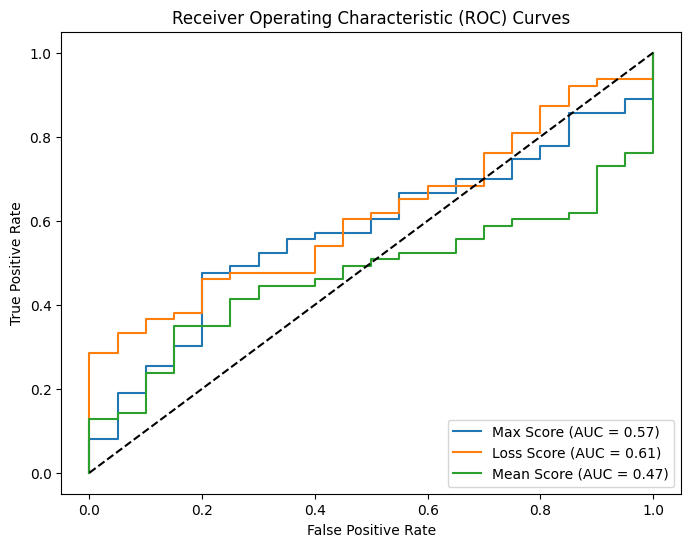

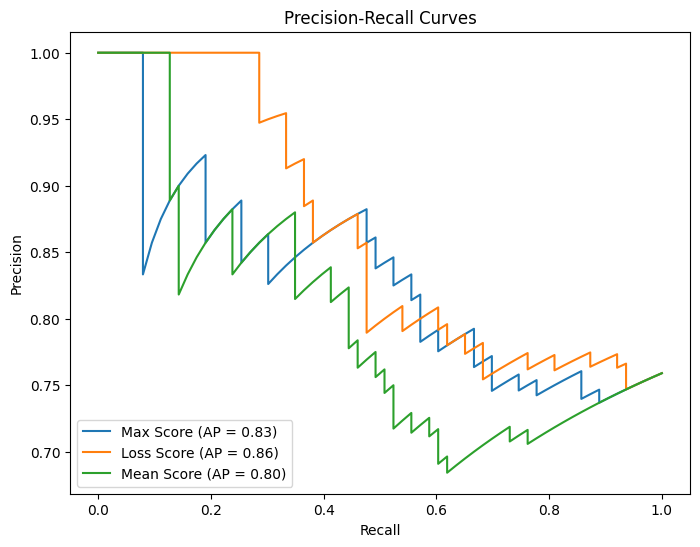

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

# Assuming the variables labels, max_scores, loss_scores, and mean_scores are already defined as per your code

# Calculate ROC Curve and AUC for each score type
fpr_max, tpr_max, _ = roc_curve(labels, max_scores)
roc_auc_max = auc(fpr_max, tpr_max)

fpr_loss, tpr_loss, _ = roc_curve(labels, loss_scores)
roc_auc_loss = auc(fpr_loss, tpr_loss)

fpr_mean, tpr_mean, _ = roc_curve(labels, mean_scores)
roc_auc_mean = auc(fpr_mean, tpr_mean)

# Plot ROC curves
plt.figure(figsize=(8, 6))
plt.plot(fpr_max, tpr_max, label=f'Max Score (AUC = {roc_auc_max:.2f})')
plt.plot(fpr_loss, tpr_loss, label=f'Loss Score (AUC = {roc_auc_loss:.2f})')
plt.plot(fpr_mean, tpr_mean, label=f'Mean Score (AUC = {roc_auc_mean:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Dashed diagonal
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right")
plt.show()

# Calculate Precision-Recall Curve and Average Precision for each score type
precision_max, recall_max, _ = precision_recall_curve(labels, max_scores)
ap_max = average_precision_score(labels, max_scores)

precision_loss, recall_loss, _ = precision_recall_curve(labels, loss_scores)
ap_loss = average_precision_score(labels, loss_scores)

precision_mean, recall_mean, _ = precision_recall_curve(labels, mean_scores)
ap_mean = average_precision_score(labels, mean_scores)

# Plot Precision-Recall curves
plt.figure(figsize=(8, 6))
plt.plot(recall_max, precision_max, label=f'Max Score (AP = {ap_max:.2f})')
plt.plot(recall_loss, precision_loss, label=f'Loss Score (AP = {ap_loss:.2f})')
plt.plot(recall_mean, precision_mean, label=f'Mean Score (AP = {ap_mean:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend(loc="lower left")
plt.show()


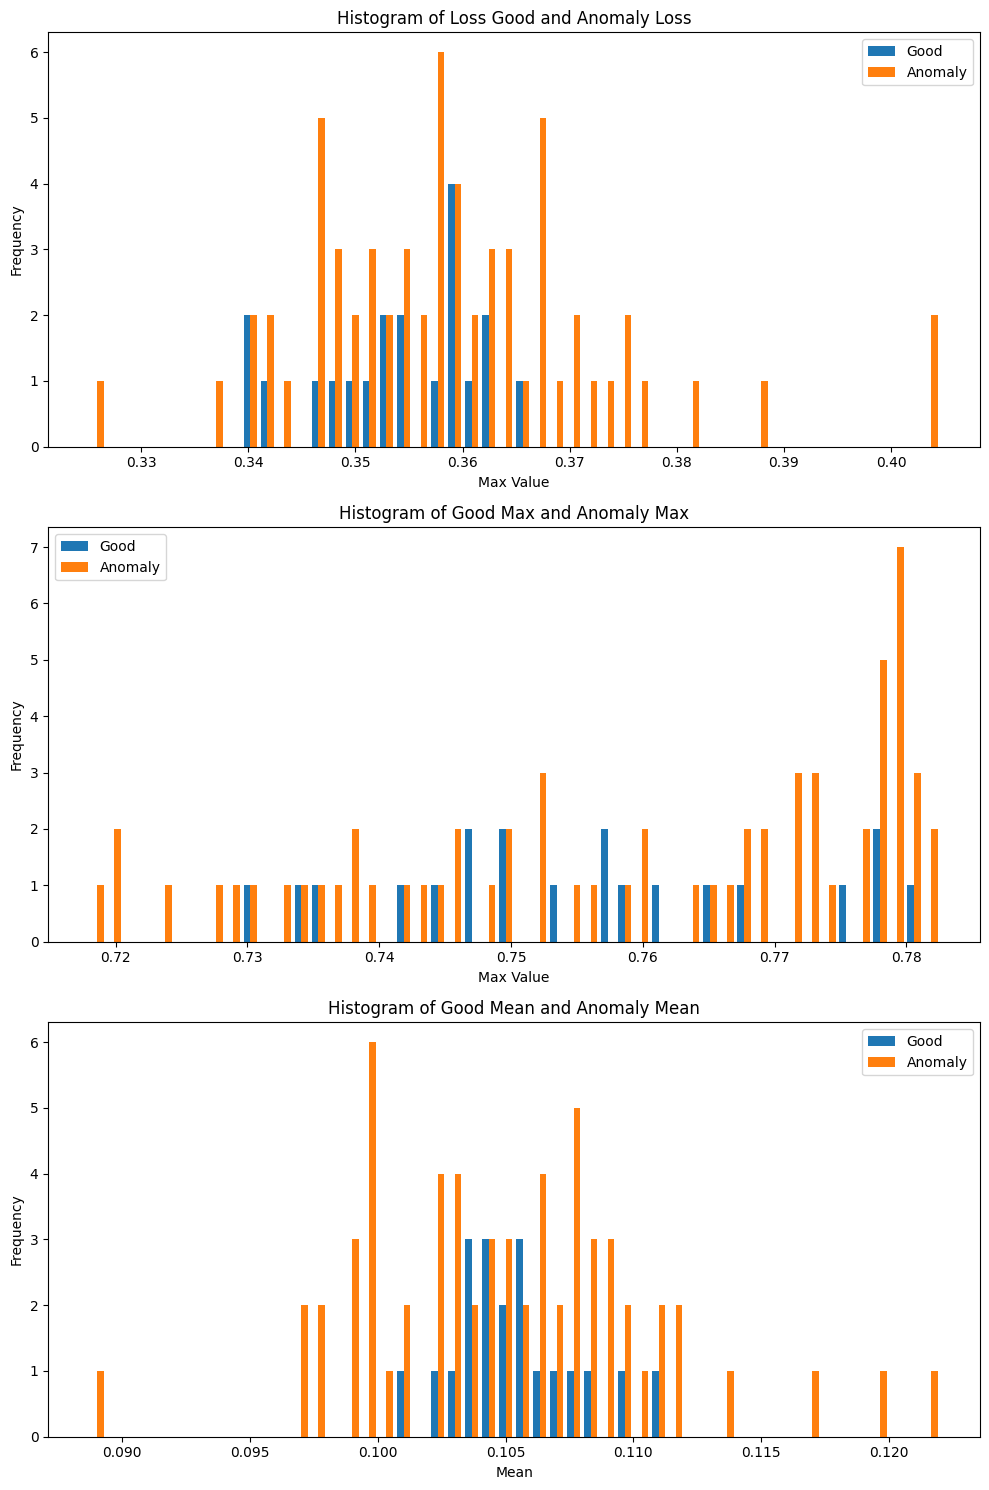

In [9]:
# histogram of scores

fig, axs = plt.subplots(3, 1, figsize=(10, 15))
axs[0].hist([loss_good, loss_ano], bins=50, label=['Good', 'Anomaly'])
axs[0].set_xlabel('Max Value')
axs[0].set_ylabel('Frequency')
axs[0].set_title('Histogram of Loss Good and Anomaly Loss')
axs[0].legend()
axs[1].hist([good_max, ano_max], bins=50, label=['Good', 'Anomaly'])
axs[1].set_xlabel('Max Value')
axs[1].set_ylabel('Frequency')
axs[1].set_title('Histogram of Good Max and Anomaly Max')
axs[1].legend()
axs[2].hist([good_mean, ano_mean], bins=50, label=['Good', 'Anomaly'])
axs[2].set_xlabel('Mean')
axs[2].set_ylabel('Frequency')
axs[2].set_title('Histogram of Good Mean and Anomaly Mean')
axs[2].legend()
plt.tight_layout()
plt.show()


## conclusions
darker regions with lowe3r values get higher score when the reconstruction is random 



